# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## Project 1:
## Simulation of House Prices in Ireland

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gamma
import httpx
from selectolax.parser import HTMLParser
import time
import warnings
import random

In [125]:
# Set seed for reproducibility
np.random.seed(10)

# Number of samples
num_samples = 1000

### **Introduction**
For this data analytics project, I have chosen to simulate a dataset related to house prices in Ireland. 

I needed to figure out some simple house statistics such as the average floor area and the minimum house price. The CSO (Central Statistic Office) only provides simulated datasets. Simulating data on a simuted dataset may not be the best idea so I decided to scrape a sample number of properties on daft.ie.

### **Variables**

1. Price
1. Floor Area
1. Number of Bedrooms
1. Property Type
1. Location

In [3]:
def get_html(baseurl, page):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"}
    resp = httpx.get(baseurl + str((page*20)-20), headers=headers)
    resp.raise_for_status()
    try:
        resp.raise_for_status()
    except httpx.HTTPStatusError as exc:
        print(f"Error response {exc.response.status_code} while requesting {exc.request.url!r}. Page Limit Exceeded")
        return False # Returns False when it exceeds the last webpage in order to stop the loop.
    html = HTMLParser(resp.text)
    return html

In [4]:
def extract_text(html, sel):
    try:
        text = html.css_first(sel).text(strip=True)
        return clean_data(text)
    except AttributeError:
        return None

In [5]:
def parse_page(html):
    card_elements = html.css("div[data-testid='card-body']")

    for card_element in card_elements:
        property_info = {
            "County": extract_text(card_element, "[data-testid='address']"),
            "Price": extract_text(card_element, "[data-testid='price']"),
            "Bedrooms": extract_text(card_element, "[data-testid='beds']"),
            "Bathrooms": extract_text(card_element, "[data-testid='baths']"),
            "Floor Area": extract_text(card_element, "[data-testid='floor-area']"),
            "Property Type": extract_text(card_element, "[data-testid='property-type']")
        }
        yield property_info

In [6]:
def clean_data(value):
    chars_to_remove = ["€", "m²", "Bed", "Bath", "ONLINE OFFERS", "ONLINE OFFER", "AMV:"]
    for char in chars_to_remove:
        if char in value:
            value = value.replace(char, "")
    return value.strip()

In [7]:
def daft_scraper(num_of_pages_to_scrape = 11):
    baseurl = "https://www.daft.ie/property-for-sale/ireland?pageSize=20&from="
    df_list = []
    
    print("Gathering Page:")
    for x in range(1,num_of_pages_to_scrape):
        print(f"{x}", end=" ")
        html = get_html(baseurl, x)
        if html is False:
            break
        data = parse_page(html)

        for item in data:
            df_list.append(item)
            
        time.sleep(0)

    scraped_df = pd.DataFrame(df_list)
    
    scraped_df["Price"] = pd.to_numeric(scraped_df["Price"].str.replace(",", ""), errors="coerce")
    scraped_df["Bedrooms"] = pd.to_numeric(scraped_df["Bedrooms"], errors="coerce")
    scraped_df["Bathrooms"] = pd.to_numeric(scraped_df["Bathrooms"], errors="coerce")
    scraped_df["Floor Area"] = pd.to_numeric(scraped_df["Floor Area"], errors="coerce")

    return scraped_df

In [8]:
scraped_df = daft_scraper(101)

Gathering Page:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [9]:
df = pd.DataFrame()
df["Price"] = scraped_df["Price"].fillna(0).astype(int)
df["Bedrooms"] = scraped_df["Bedrooms"].fillna(0).astype(int)
df["Floor Area"] = scraped_df["Floor Area"].fillna(0).astype(int)
df["Property Type"] = scraped_df["Property Type"].astype("category")
df["County"] = scraped_df["County"].str.rsplit(',', n=2).str[-2]
df["County"] = df["County"].str.split('.', n=1).str[1]

df = df[(df["Price"] != 0) & (df["Bedrooms"] != 0) & (df["Floor Area"] != 0) & (df["Property Type"] != "Site") & (df["Price"] < 2_000_000) & (df["Floor Area"] < 500) & (df["Bedrooms"] <= 8)]

df.dropna(inplace=True)
df["Property Type"] = df["Property Type"].cat.remove_unused_categories()

df.reset_index(drop=True, inplace=True)

### **House Price:**

This variable represents the market value of a house. It will be a continuous variable with a positive integer format.

**Data Generation**

Simulate house prices using a normal distribution. Research on local housing markets can provide insights into the mean and standard deviation for generating realistic price data.

Function made in other module. Fundamentals.

**Function distribution_test(variable_name) to automatically identify the best-fitting distribution among multiple continuous variable candidates using Kolmogorov–Smirnov Test (KS), P-Values, and  Akaike Information Criterion (AIC)**

In [10]:
def distribution_test(variable_name):
    
    results = []  # To store the results
    numpy_distributions = ['beta', 'chi2', 'expon', 'f', 'gamma', 'gumbel_r', 'gumbel_l', 'laplace', 'logistic', 'lognorm', 'norm', 'pareto', 
                           'powerlaw', 'powerlognorm', 'rayleigh', 'cauchy', 'exponpow', 't', 'triang', 'uniform', 'wald', 'weibull_min', 'weibull_max']

    for distribution in numpy_distributions:
        params = getattr(stats, distribution).fit(variable_name)
        stat, p_value = stats.kstest(variable_name, distribution, args=params)
        
        # Calculate AIC
        dist = getattr(stats, distribution)(*params)
        log_likelihood = dist.logpdf(variable_name).sum()
        k = len(params)  # Number of parameters
        aic = 2 * k - 2 * log_likelihood
        
        # Store the results in a dictionary
        result = {
            'Distribution': distribution,
            'KS Statistic': stat,
            'P-value': p_value,
            'AIC': aic
        }
        results.append(result)

    # Create a DataFrame from the results
    test_df = pd.DataFrame.from_dict(results)
    test_df = test_df.sort_values(by='KS Statistic', ascending=True).reset_index(drop=True).head(10)
    
    return test_df

In [11]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

The price data looked like it was too wide ranging so it was transformed into logarithm.

In [12]:
transformed_price = np.log(df["Price"])

In [13]:
distribution_test(transformed_price)

,Distribution,KS Statistic,P-value,AIC
0,t,0.029206,0.393545,1633.583412
1,logistic,0.032275,0.277180,1635.787434
2,lognorm,0.032966,0.254741,1640.349293
3,gamma,0.034112,0.220558,1639.954019
4,f,0.034407,0.212327,1642.033380
5,norm,0.034547,0.208537,1637.914518
6,powerlognorm,0.034601,0.207056,1641.591422
7,beta,0.034749,0.203117,1641.907311
8,weibull_min,0.054520,0.007329,1668.648050
9,laplace,0.057265,0.004114,1693.807340


In [14]:
mean_price = df["Price"].mean()
sigma_price = df["Price"].std()

# Convert these parameters to the mean of the log-normal distribution
mean_log = np.log(mean_price**2 / np.sqrt(mean_price**2 + sigma_price**2))
sigma_log = np.sqrt(np.log(1 + (sigma_price**2 / mean_price**2)))

simulated_house_price = np.random.lognormal(mean_log, sigma_log, num_samples)

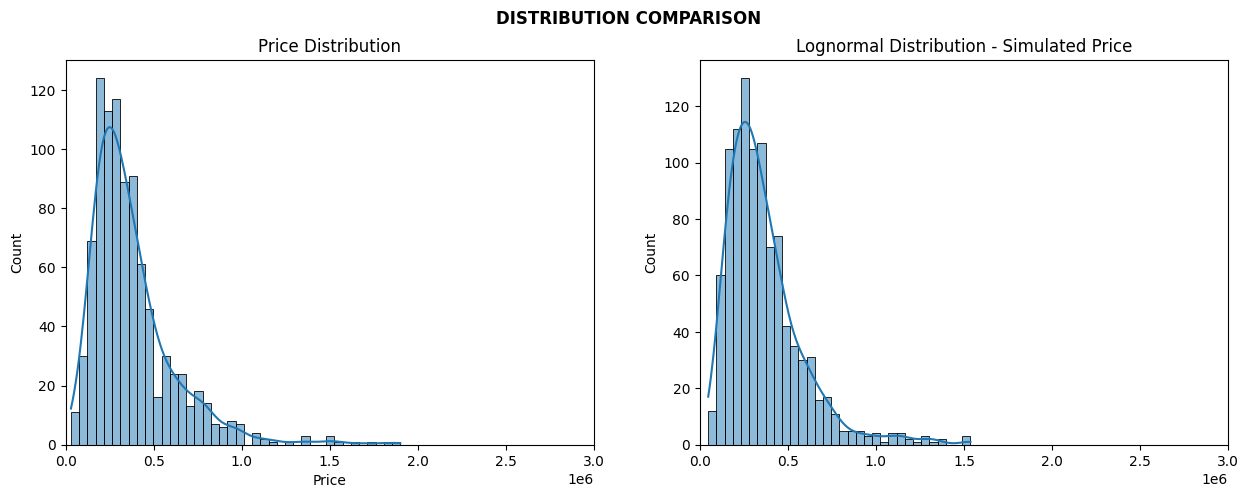

In [34]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Price Distribution')
axes[0].set_xlim(0, 3_000_000)
sns.histplot(df["Price"], kde=True, ax=axes[0])

axes[1].set_title('Simulated Price- Lognormal Distribution')
axes[1].set_xlim(0, 3_000_000)
sns.histplot(simulated_house_price, kde=True, ax=axes[1]);

### **Floor Area:**

The floor area of the house in meters squared. This will be a positive integer.

**Data Generation**

Simulate floor area using a gamma distribution.

In [16]:
transformed_floor_area = np.log(df["Floor Area"])

In [17]:
distribution_test(transformed_floor_area)

,Distribution,KS Statistic,P-value,AIC
0,chi2,0.036400,0.162864,1286.204073
1,logistic,0.037761,0.134695,1305.194638
2,weibull_min,0.037969,0.130765,inf
3,powerlognorm,0.040548,0.089317,1285.519891
4,gamma,0.042635,0.064422,1284.480272
5,lognorm,0.042804,0.062687,1284.364943
6,beta,0.042961,0.061127,1286.538984
7,f,0.042998,0.060758,1286.350253
8,weibull_max,0.044330,0.048808,1284.401785
9,t,0.047781,0.026827,1285.222786


This code uses the gamma.fit function from SciPy to estimate the shape, location, and scale parameters of the gamma distribution that best fit the floor area data.

In [87]:
alpha, loc, beta = stats.gamma.fit(df["Floor Area"])

# Generate random samples from the fitted distribution
simulated_floor_area = gamma.rvs(alpha, loc=loc, scale=beta, size=num_samples)

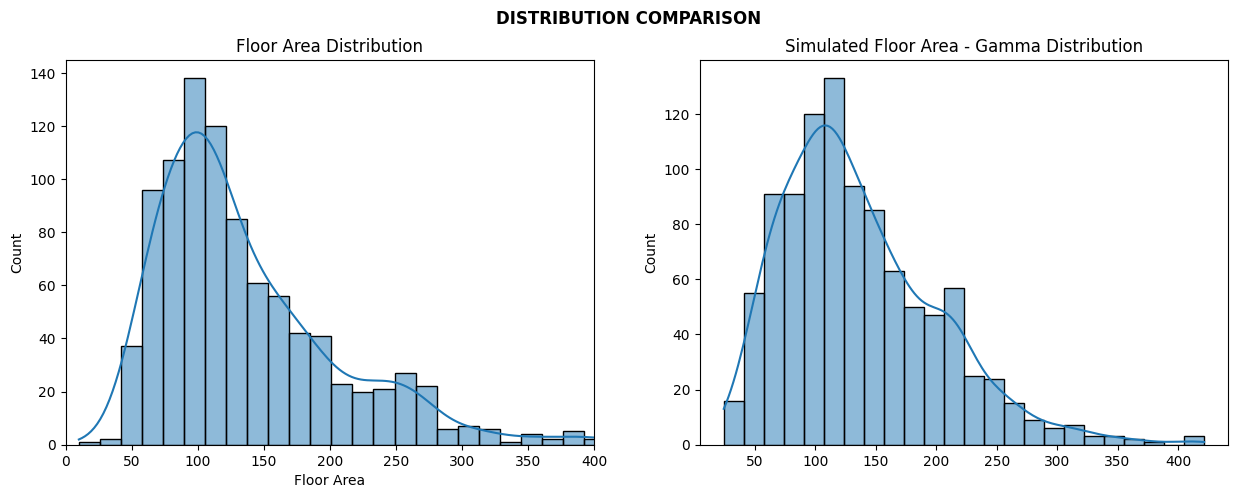

In [88]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Floor Area Distribution')
axes[0].set_xlim(0, 400)
sns.histplot(df["Floor Area"], kde=True, ax=axes[0])

axes[1].set_title('Simulated Floor Area - Gamma Distribution')
sns.histplot(simulated_floor_area, kde=True, ax=axes[1]);

#### **Number of Bedrooms:**

The count of bedrooms in a house. This will be a positive integer.

**Data Generation**

Simulate the number of bedrooms using a discrete distribution. Research on typical bedroom counts in houses can guide the distribution.

In [102]:
c = df["Bedrooms"].value_counts()

In [107]:
# Get the count of each unique value in the 'Bedrooms' column
count_of_bedrooms = df["Bedrooms"].value_counts()

# Calculate the sum of bedrooms
sum_of_bedrooms = count_of_bedrooms.sum()

# Calculate the distribution of bedrooms
bedroom_distribution = (count_of_bedrooms / sum_of_bedrooms).sort_index()

# Convert the distribution to a list
p = bedroom_distribution.tolist()

# Simulate the number of bedrooms without noise based on the distribution
simulated_number_of_bedroom_without_noise = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], size=num_samples, p=p)

# Add random noise to the simulated bedrooms
noise = np.random.randint(-1, 2, num_samples)
simulated_number_of_bedrooms = np.clip(simulated_number_of_bedroom_without_noise + noise, 1, 8)

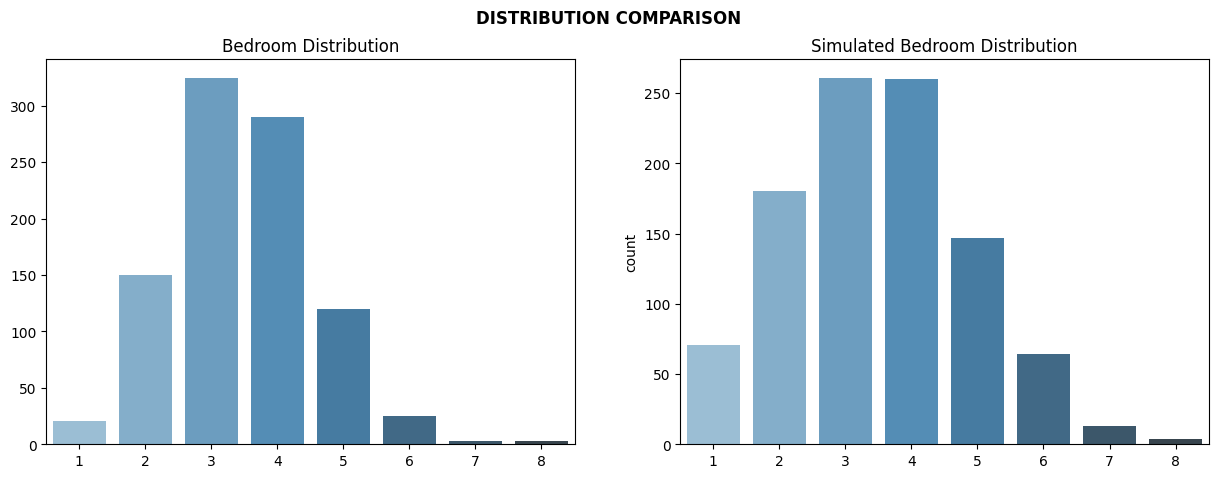

In [108]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
figure.suptitle('DISTRIBUTION COMPARISON', fontweight='bold')

axes[0].set_title('Bedroom Distribution')
sns.barplot(x=c.index,y=c.values, palette='Blues_d', ax=axes[0])

axes[1].set_title('Simulated Bedroom Distribution')
sns.countplot(x=simulated_number_of_bedrooms, palette='Blues_d', ax=axes[1]);

### **Location**

In [25]:
price_by_county = df.groupby("County")["Price"].agg(['mean', 'std']).round(2)
price_by_county_df = price_by_county.reset_index().sort_values(by="mean", ascending=False)

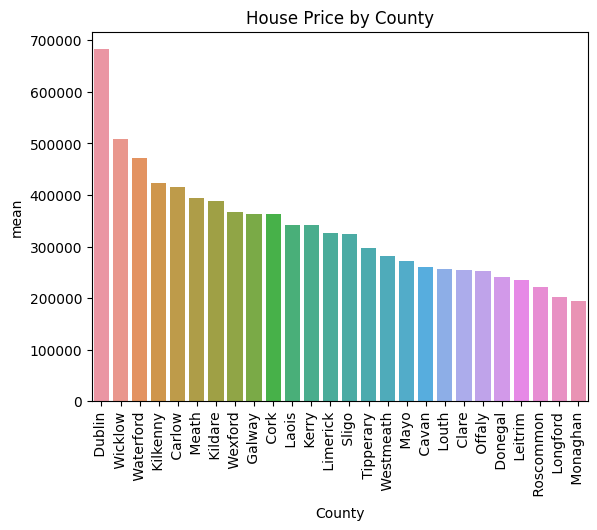

In [122]:
plt.title("House Price by County")
plt.xticks(rotation=90)
sns.barplot(x="County", y="mean", data=price_by_county_df);

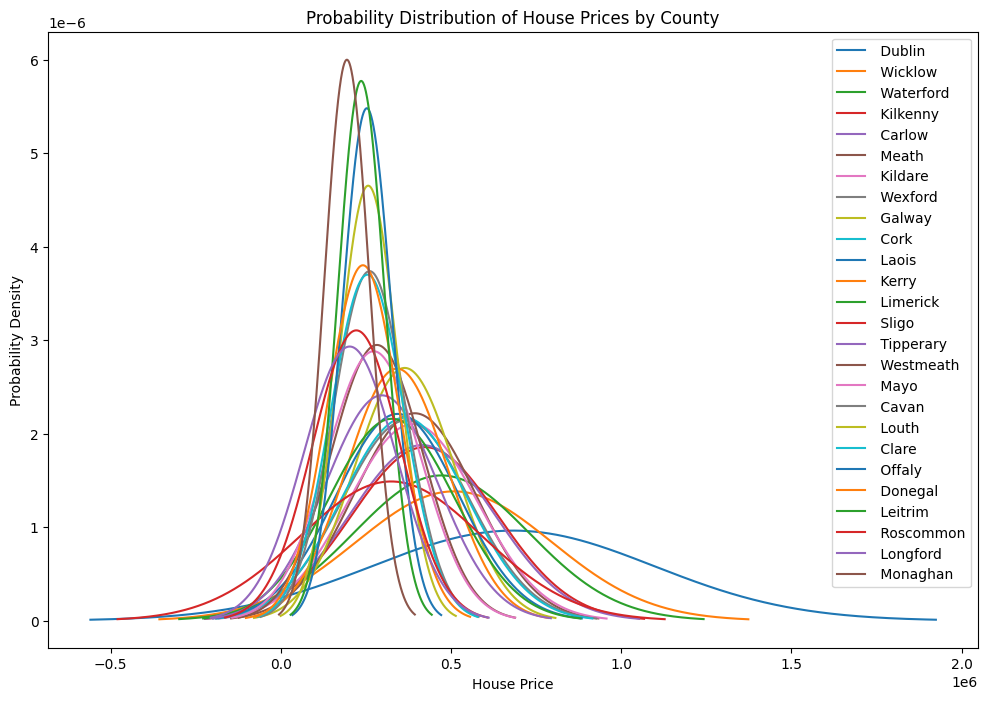

In [124]:
# Plotting the fitted normal distribution for each county

plt.figure(figsize=(12, 8))

for i, row in price_by_county_df.iterrows():
    mean = row['mean']
    std = row['std']
    dist = norm(loc=mean, scale=std)

    x = np.linspace(mean - 3 * std, mean + 3 * std, 1000)
    y = dist.pdf(x)

    plt.plot(x, y, label=row['County'])

plt.title('Probability Distribution of House Prices by County')
plt.xlabel('House Price')
plt.ylabel('Probability Density')
plt.legend();

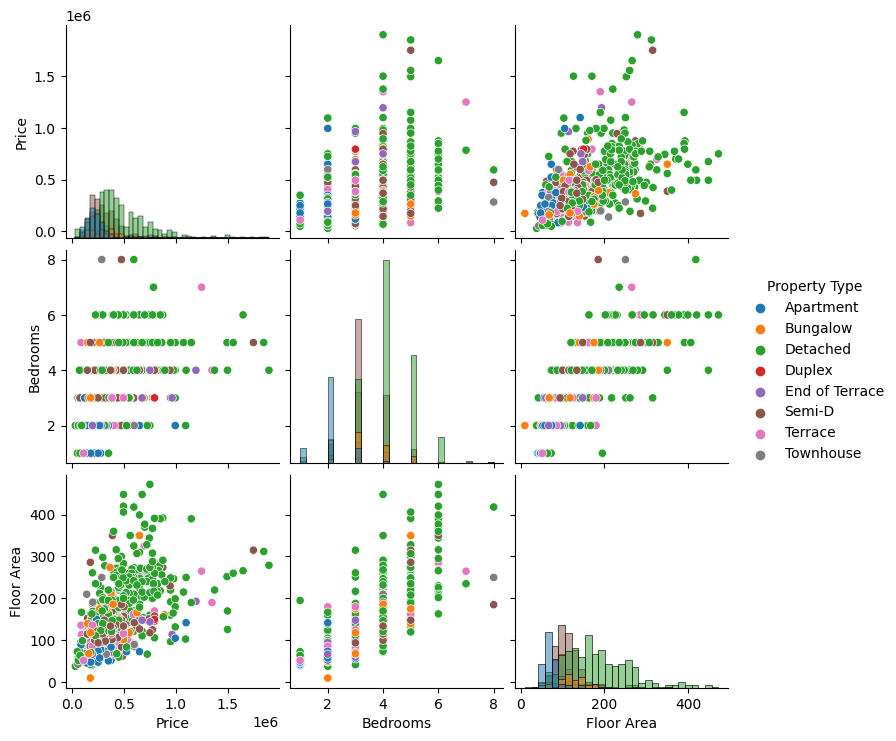

In [28]:
sns.pairplot(df, hue="Property Type", diag_kind='hist');

<Axes: title={'center': 'Heatmap: Correlation'}>

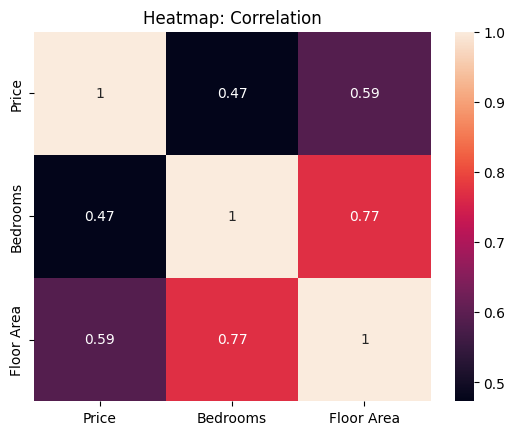

In [29]:
df_corr = df[['Price','Bedrooms','Floor Area']].corr()
plt.title('Heatmap: Correlation')
sns.heatmap(df_corr, annot=True)

In [82]:
list_counties = []

for i in range(11):
    county = 'Simulated_County ' + str(i)
    # append county name to the list of counties
    list_counties.append(county)

counties_list_length = num_samples

simulated_counties = random.choices(list_counties, k=counties_list_length)

In [84]:
len(simulated_counties)

1000

In [85]:
len(simulated_house_price)

1000

In [90]:
len(simulated_floor_area)

1000

In [109]:
len(simulated_number_of_bedrooms)

1000

In [132]:
simulated_df = pd.DataFrame({
    'Simulated County': simulated_counties,
    'Simulated Price': simulated_house_price,
    'Simulated Bedrooms': simulated_number_of_bedrooms,
    'Simulated Floor Area': simulated_floor_area
})

In [133]:
simulated_df

,Simulated County,Simulated Price,Simulated Bedrooms,Simulated Floor Area
0,Simulated_County 3,694787.712023,4,63.887385
1,Simulated_County 7,483341.427031,8,131.353826
2,Simulated_County 10,127693.262481,4,136.994321
3,Simulated_County 2,315648.493557,5,148.676028
4,Simulated_County 10,457331.940100,3,52.660036
...,...,...,...,...
995,Simulated_County 4,174569.126828,2,125.220278
996,Simulated_County 3,260912.432660,4,206.211288
997,Simulated_County 6,740889.176396,4,166.400743
998,Simulated_County 3,252094.654981,3,103.636976


In [134]:
simulated_df.describe()

,Simulated Price,Simulated Bedrooms,Simulated Floor Area
count,1.000000e+03,1000.000000,1000.000000
mean,3.663778e+05,3.496000,136.475194
std,2.190543e+05,1.397117,64.738591
min,4.807720e+04,1.000000,24.087183
25%,2.177430e+05,2.000000,90.135731
50%,3.128562e+05,3.000000,122.756877
75%,4.518921e+05,4.000000,173.564554
max,1.536868e+06,8.000000,421.682327


In [135]:
df.describe()

,Price,Bedrooms,Floor Area
count,9.370000e+02,937.000000,937.000000
mean,3.772505e+05,3.469584,137.369264
std,2.428436e+05,1.106210,70.993140
min,3.000000e+04,1.000000,10.000000
25%,2.190000e+05,3.000000,89.000000
50%,3.150000e+05,3.000000,116.000000
75%,4.500000e+05,4.000000,168.000000
max,1.900000e+06,8.000000,472.000000


In [144]:
correlation_matrix = simulated_df[["Simulated Price", "Simulated Bedrooms", "Simulated Floor Area"]].corr(method='pearson', min_periods=1)

print(correlation_matrix)

                      Simulated Price  Simulated Bedrooms  \
Simulated Price              1.000000            0.015972   
Simulated Bedrooms           0.015972            1.000000   
Simulated Floor Area        -0.056670           -0.045836   

                      Simulated Floor Area  
Simulated Price                  -0.056670  
Simulated Bedrooms               -0.045836  
Simulated Floor Area              1.000000  



https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best/


https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
https://statisticsbyjim.com/basics/goodness-of-fit/
https://statisticsbyjim.com/basics/skewed-distribution/

https://docs.scipy.org/doc/scipy/reference/stats.html

Note that this example covers continuous data. For categorical and discrete variables, you should use the chi-square goodness of fit test.

https://statisticsbyjim.com/hypothesis-testing/chi-square-goodness-of-fit-test/



https://archive.ph/20230811082152/https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd#selection-643.182-653.170

https://www.datacamp.com/tutorial/probability-distributions-python

https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/https://archive.ph/20221125141253/https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f#selection-965.3-979.30

https://numpy.org/doc/1.16/reference/routines.random.html

https://stackoverflow.com/questions/45579525/returning-a-dataframe-in-python-function

https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/


https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart


https://stackoverflow.com/questions/69141790/seaborn-reg-plots-with-the-same-y-axis-scale-side-by-side


Right Skewed. The mean overestimates the most common values in a positively skewed distribution.

Using a QQ Plot to determine if the dristribution follows a probability distribution...?

https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_gumbel_l.html


https://www.statista.com/statistics/1417857/ireland-mean-new-home-size/

https://ec.europa.eu/eurostat/cache/digpub/housing/bloc-1b.html?lang=en

https://www.cso.ie/en/interactivezone/syntheticdata/housepricesyntheticdataset/

https://en.wikipedia.org/wiki/Parametric_statistics

https://www.youtube.com/@JohnWatsonRooney/videos

https://www.youtube.com/watch?v=1PCWwK0AsE0
https://www.youtube.com/watch?v=ZgVus_rmDBQ

https://visual.cso.ie/?body=entity/rppi

https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas

https://www.youtube.com/watch?v=xtTX69JZ92w

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponpow.html

https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

https://datatofish.com/convert-pandas-dataframe-to-list/

https://numpy.org/doc/stable/reference/generated/numpy.clip.html

https://en.wikipedia.org/wiki/Covariance_matrix

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

***Add more references and sort them out.***

***
# End